<a href="https://colab.research.google.com/github/edenau/maps/blob/master/map_density.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import

import folium
from folium.plugins import MarkerCluster

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

In [0]:
# Mount Google Drive locally

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Load journey data

f = '/content/gdrive/My Drive/Colab Notebooks/folium/journeys.csv'
j = pd.read_csv(f)

date = j['day'].values
month = j['month'].values
year = j['year'].values
hour = j['hour'].values
minute = j['min'].values
station_start = j['id_start'].values
station_end = j['id_end'].values

In [0]:
# Compute IsWeekday

weekday = np.zeros(len(date))
weekday[:] = np.nan
cnt = 0

for _year, _month, _date, _hour, _minute in zip(year, month, date, hour, minute):
  _dt = dt.datetime(_year, _month, _date, _hour, _minute)
  _weekday = _dt.weekday()
  weekday[cnt] = _weekday
  cnt += 1

IsWeekday = weekday < 5
j['IsWeekday'] = IsWeekday

# Compute TimeSlice

j['TimeSlice'] = (hour*3 + np.floor(minute/20)).astype(int)

In [0]:
# Load station data

f = '/content/gdrive/My Drive/Colab Notebooks/folium/stations.csv'
stations = pd.read_csv(f)
station_id = stations['station_id'].values

In [0]:
# Extract valid journeys

valid = np.zeros(len(date))
valid[:] = False
cnt = 0

for _start, _end in zip(station_start, station_end):
  if np.logical_and((_start in station_id), (_end in station_id)):
    valid[cnt] = True
  cnt += 1

j['Valid'] = valid

In [0]:
# Only keep valid and weekday journeys

df = j[j["IsWeekday"] == True].drop(columns="IsWeekday")
df = df[df["Valid"] == True].drop(columns="Valid")

print('Ratio of valid journeys= {:.2f}%'.format(df.shape[0] / j.shape[0] * 100))

Ratio of valid journeys= 73.29%


In [0]:
# Clean data

df = df.loc[:, ['TimeSlice', 'id_start', 'id_end', 'duration']]
df

,TimeSlice,id_start,id_end,duration
0,52,251,478,2040.0
1,44,550,122,1800.0
2,50,212,639,1140.0
3,36,163,755,420.0
4,57,36,605,1200.0
5,43,589,514,1320.0
8,40,153,367,540.0
9,47,396,350,960.0
10,26,732,298,420.0
11,51,818,796,1620.0


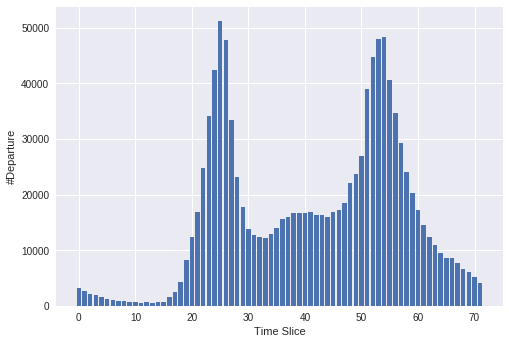

Peak Timeslice= 25


In [0]:
# Plot example

grp_by_timeslice = df.groupby('TimeSlice').count().values[:,0]

plt.bar(range(0,72), grp_by_timeslice)
plt.xlabel('Time Slice')
plt.ylabel('#Departure')
plt.show()

print('Peak Timeslice= {}'.format(grp_by_timeslice.argmax()))

In [0]:
# Build DensityMap function

def DensityMap(stations, cnt_departure, cnt_arrival):

  London = [51.506949, -0.122876]
  
  map = folium.Map(location = London, 
                   zoom_start = 12, 
                   tiles = "CartoDB dark_matter")
  
  stations['Total Departure'] = cnt_departure
  stations['Total Arrival'] = cnt_arrival

  for index, row in stations.iterrows():
    net_departure = row['Total Departure'] - row['Total Arrival']
    
    _radius = np.abs(net_departure) 
    if np.isnan(_radius):
      _radius = 0
    
    if net_departure > 0:
      _color= '#E80018' # target red
    else:
      _color= '#81D8D0' # tiffany blue
  
    lat, lon = row['lat'], row['lon']
    _popup = '('+str(row['capacity'])+'/'+str(int(_radius))+') '+row['station_name']
  
    folium.CircleMarker(location = [lat,lon], 
                        radius = _radius, 
                        popup = _popup, 
                        color = _color, 
                        fill_opacity = 0.5).add_to(map)
  
  return map
  

In [0]:
# Select peak hours

TimeSlice = [25,53] # morning and evening
keyword = ['map_morning', 'map_evening']

# Journeys depart between 0820 and 0859, and between 1740 and 1819
for ts, kw in zip(TimeSlice, keyword):
  df_1 = df[df["TimeSlice"] == ts]
  df_2 = df[df["TimeSlice"] == (ts+1)]
  df_target = df_1.append(df_2)

  cnt_departure = df_target.groupby("id_start").count().iloc[:,0]
  cnt_arrival = df_target.groupby("id_end").count().iloc[:,0]

  vars()[kw] = DensityMap(stations, cnt_departure, cnt_arrival)

In [0]:
map_morning

In [0]:
map_evening

In [0]:
# Save the map

f = "/content/gdrive/My Drive/Colab Notebooks/folium/map_morning.html"
map_morning.save(f)

f = "/content/gdrive/My Drive/Colab Notebooks/folium/map_evening.html"
map_evening.save(f)